#### Bayes Classification Example

> Taken from somewhere (and modified)

Imports

In [1]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt

#### Import data

In [2]:

def load_csv(filename):
    lines = csv.reader(open(filename, "r", encoding='utf-8-sig'))
    dataset = list(lines)
    for i in range(len(dataset)):
        dataset[i] = [float(x) for x in dataset[i]]
    dataset = np.asarray(dataset, dtype=np.float32)
    return dataset

# trainingData = load_csv('file/ds_zipcode_train.csv')
trainingData = load_csv('file/ds_train.csv')
# testingData = load_csv('file/ds_zipcode_test.csv')
testingData = load_csv('file/ds_test.csv')

### Utils

In [6]:
def getRowsGroupedByClass(dataset: list) -> tuple:
    '''
        Returns tuple holding the dataset with rows grouped by class and the classes list.
    '''
    classes = np.unique(dataset[:, np.size(dataset, 1) - 1])
    sortedclassdata = []
    for i in range(len(classes)):
        item = classes[i]
        itemIdxList = np.where(dataset[:, np.size(dataset, 1) - 1] == item)     # index  of rows with label class[i]
        singleclassdataset = dataset[itemIdxList, 0:np.size(dataset, 1) - 1]    # array of data for class[i]
        sortedclassdata.append(np.matrix(singleclassdataset))                   # matrix of data for class[i]
    return sortedclassdata, classes

def getPriorProbabilities(dataset: list, gropedData: list) -> list:
    '''
        Returns the probabilities of occurency of each class in the dataset.
        - Posterior prob = likelihood * prior probability;
    '''
    priorProbs = []
    for i in range(len(gropedData)):
        priorProbs.append(len(gropedData[i]) / len(dataset))
    return priorProbs


def getClassesMeans(gropedData) -> list:
    '''
        Returns list of each dataset class data means/
    '''
    classMeans = []
    for i in range(len(gropedData)):
        classMeans.append(gropedData[i].mean(0))
    return classMeans

def getCovarianceMatrix(groupedData: list, classMeans: list) -> list:
    covMatrix = []
    
    for i in range(len(classMeans)):
        
        rows = groupedData[i]
        mean = np.transpose(classMeans[i])
        rowsT = np.transpose(rows)
        nRows = len(rows)
        
        aux = [(rowsT[:, row] - mean) * np.transpose(rowsT[:, row] - mean) for row in range(nRows)]
        covMatrix.append(sum(aux) / (nRows - 1))

    return covMatrix

def getClassification(dataset: list, classMeans: list, covarianceMatrix: list, priorProbs: list, classes: list) -> list:
    '''
        Returns likelihood, given a gaussian distribution.
        - Uses the mean and variance (or in this case, the covariance);
        
        NOTE: see eq(1.52) pg.25 Pattern Recognition and Machine Learaning
    '''

    yHat = []
    nRows = len(dataset)
    nClasses = len(classes)
    nFeatures = len(covarianceMatrix[0])

    dataset = np.matrix(dataset)
    datasetT = np.transpose(dataset[:, 0:nFeatures])
    
    for i in range(nRows):
        row = datasetT[:, i]
        probabilities = [] # Probabilities for each class relative to this row
        
        for j in range(nClasses):

            # Who knows...            
            det = np.linalg.det(covarianceMatrix[j])
            if det == 0:
                addValue = 0.006 * np.identity(nFeatures)
                covarianceMatrix[j] = addValue + covarianceMatrix[j]
                det = np.linalg.det(covarianceMatrix[j])
            
            # Compute probability for this class in this row
            exponent = (-0.5)*np.transpose(row-np.transpose(classMeans[j]))*np.linalg.inv(covarianceMatrix[j])*(row-np.transpose(classMeans[j]))
            probability = priorProbs[j] * (1/((2*math.pi)**(nFeatures/2)))*(1/(det**0.5))*math.exp(exponent)
            probabilities.append(probability)
        
        # Compute predicted class for this row
        predictedClassIdx = np.argmax(np.array(probabilities))
        predictedClass = classes[predictedClassIdx]
        yHat.append(predictedClass)

    return yHat

def getAccuracy(yHat: list, dataset: list) -> float:
    
    nClasses = dataset.shape[1] - 1
    y = np.asarray(dataset[:, nClasses])
    yHat = np.asarray(yHat, dtype=np.float32)
    
    yHatT = np.transpose([yHat])
    yT = np.transpose([y])
    aux = np.equal(yHatT, yT)
    
    return np.sum(aux) / dataset.shape[0]

### Classify

Plot utils

In [11]:
def plot_by_class_better(dataset, classes, title):
    dataset[:, 2] = classes
    x0 = [row[0] for row in dataset if 0 in row]
    y0 = [row[1] for row in dataset if 0 in row]
    x1 = [row[0] for row in dataset if 1 in row]
    y1 = [row[1] for row in dataset if 1 in row]
    plt.scatter(x0, y0, label='0', color="red", marker="o", s=30)
    plt.scatter(x1, y1, label='1', color="blue", marker="o", s=30)
    plt.xlabel('x - axis')
    plt.ylabel('y - axis')
    plt.title(title)
    plt.show()
    return

Classify

100.0% Correct on Training Data using Bayes Classifier


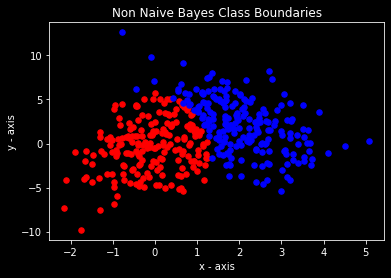

In [12]:


# Posterior prob = likelihood * prior probability;
# To find likelihood we find mean and covariance first;
groupedData, classes = getRowsGroupedByClass(trainingData)
priorProbs = getPriorProbabilities(trainingData, groupedData)
means = getClassesMeans(groupedData)
covarianceMatrix = getCovarianceMatrix(groupedData, means)
yHat = getClassification(testingData, means, covarianceMatrix, priorProbs, classes)

accuracy = getAccuracy(yHat, testingData)
print(f"{accuracy * 100}% Correct on Training Data using Bayes Classifier")

# The following is used to plot the class boundaries
plot_by_class_better(testingData , yHat, 'Non Naive Bayes Class Boundaries')
